# **Preprocessing of the Carvana Dataset**

The [Carvana Image Masking](https://www.kaggle.com/competitions/carvana-image-masking-challenge/) dataset, introduced in 2017 on the [Kaggle](https://www.kaggle.com/) platform as part of an image segmentation challenge, consists of 105,152 high-resolution images of cars from various brands. Out of these, 5,088 images are used for training and 100,064 for testing. Only the training set includes binary masks associated with a single class, **car**, which are publicly available. 

In this notebook, the training set is split into 80% for training and 20% for validation. This dataset is ideal for training basic segmentation models because the masks are binary, there is only one object type (one car per image), and the cars appear against a clean and consistent background in all images. These characteristics make it possible to achieve excellent results even when training a basic model like [**U-Net**](https://arxiv.org/abs/1505.04597) from scratch.

## **Imports**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm.auto import tqdm
from google.colab import drive
import cv2
import os

## **Parameters**

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
dataset_url = os.path.basename("https://www.kaggle.com/competitions/carvana-image-masking-challenge")
raw_dataset_dir = "/content/RawCarvana"
dataset_dir = "/content/Carvana"
zip_dataset_path = "/content/drive/MyDrive/Datasets/Carvana.zip"
val_size = 0.2
SEED = 123

## **Download and Extract the Dataset**

The dataset is available on the official [Kaggle](https://www.kaggle.com/competitions/carvana-image-masking-challenge/) website. To download it, you need to create a Kaggle account and obtain the `kaggle.json` file, which contains your API credentials. This file must then be uploaded to Google Colab or your chosen working environment to access the dataset using the Kaggle API.

In [4]:
# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download the dataset
!kaggle competitions download -c $dataset_url

100% 24.4G/24.4G [04:33<00:00, 176MB/s]
100% 24.4G/24.4G [04:33<00:00, 96.0MB/s]


In [7]:
# Unzip the dataset
!unzip {dataset_url + ".zip"} -d $raw_dataset_dir

Archive:  carvana-image-masking-challenge.zip
  inflating: /content/RawCarvana/29bb3ece3180_11.jpg  
  inflating: /content/RawCarvana/metadata.csv.zip  
  inflating: /content/RawCarvana/sample_submission.csv.zip  
  inflating: /content/RawCarvana/test.zip  
  inflating: /content/RawCarvana/test_hq.zip  
  inflating: /content/RawCarvana/train.zip  
  inflating: /content/RawCarvana/train_hq.zip  
  inflating: /content/RawCarvana/train_masks.csv.zip  
  inflating: /content/RawCarvana/train_masks.zip  


In [8]:
# Extract the high-quality training images and their masks
!unzip -q {os.path.join(raw_dataset_dir, "train_hq.zip")} -d $raw_dataset_dir
!unzip -q {os.path.join(raw_dataset_dir, "train_masks.zip")} -d $raw_dataset_dir

## **Preprocess the Dataset**

The images do not require preprocessing, while the masks are in `.gif` format. Therefore, they are converted to `.png` format, and the pixels with a value of 255 are changed to 1, making the masks ready for the binary semantic segmentation task.

In [9]:
# Create the image and mask directories
image_dir = os.path.join(dataset_dir, "images")
mask_dir = os.path.join(dataset_dir, "masks")

os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

In [10]:
# Copy all the images to the image directory
!cp -r {os.path.join(raw_dataset_dir, "train_hq/*")} $image_dir

In [11]:
# Preprocess the segmentation masks and save them
for path in tqdm(glob(os.path.join(raw_dataset_dir, "train_masks/*.gif"))):
  filename = os.path.basename(path).replace(".gif", ".png")

  mask = Image.open(path).convert("L")
  mask = np.array(mask)
  mask[mask == 255] = 1
  mask = Image.fromarray(mask)

  mask.save(os.path.join(mask_dir, filename))

  0%|          | 0/5088 [00:00<?, ?it/s]

In [12]:
# Split the image and mask paths into training and validation sets
image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

df_train, df_val = train_test_split(
    pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths}),
    test_size=val_size,
    random_state=SEED
)
print(len(df_train), len(df_val))

df_train["split"] = "train"
df_val["split"] = "val"
df_data = pd.concat([df_train, df_val]).reset_index(drop=True)
df_data

4070 1018


,image_path,mask_path,split
0,/content/Carvana/images/2990f858e939_05.jpg,/content/Carvana/masks/2990f858e939_05_mask.png,train
1,/content/Carvana/images/2f39abb12388_07.jpg,/content/Carvana/masks/2f39abb12388_07_mask.png,train
2,/content/Carvana/images/6131a03dd028_10.jpg,/content/Carvana/masks/6131a03dd028_10_mask.png,train
3,/content/Carvana/images/69915dab0755_07.jpg,/content/Carvana/masks/69915dab0755_07_mask.png,train
4,/content/Carvana/images/eb07e3f63ad2_04.jpg,/content/Carvana/masks/eb07e3f63ad2_04_mask.png,train
...,...,...,...
5083,/content/Carvana/images/f98dbe8a5ee2_01.jpg,/content/Carvana/masks/f98dbe8a5ee2_01_mask.png,val
5084,/content/Carvana/images/419687d50dcd_16.jpg,/content/Carvana/masks/419687d50dcd_16_mask.png,val
5085,/content/Carvana/images/784ca55262c2_02.jpg,/content/Carvana/masks/784ca55262c2_02_mask.png,val
5086,/content/Carvana/images/8d78483ce302_01.jpg,/content/Carvana/masks/8d78483ce302_01_mask.png,val


In [13]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5088 non-null   object
 1   mask_path   5088 non-null   object
 2   split       5088 non-null   object
dtypes: object(3)
memory usage: 119.4+ KB


In [14]:
# Save the DataFrame with the metadata
df_data.to_csv(os.path.join(dataset_dir, "metadata.csv"), index=False)

In [15]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Visualization Example**

In [16]:
# Define the classes and their respective colors
classes = {
    "background": [0, 0, 32],
    "car": [0, 0, 255]
}

In [17]:
# Function to plot images with their segmentation masks
def plot_image_masks(image_paths, mask_paths, n_rows=4, alpha=0.7, classes=classes, random=True):
  class_colors = np.array(list(classes.values()))
  background_class = list(classes.keys()).index("background")

  indices = np.arange(len(image_paths))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(n_rows, 3, figsize=(3.5 * 3, 2.5 * n_rows))
  ax[0, 0].set_title("Image", fontsize=10)
  ax[0, 1].set_title("Mask", fontsize=10)
  ax[0, 2].set_title("Blended Image", fontsize=10)

  for i in range(n_rows):
    idx = indices[i]
    image = np.array(Image.open(image_paths[idx]).convert("RGB"))
    mask_cls = np.array(Image.open(mask_paths[idx]))
    mask_rgb = class_colors[mask_cls]

    mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
    blended_image = cv2.addWeighted(image / 255, 1 - alpha, mask_rgb / 255, alpha, 0)

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(class_colors[mask_cls])
    ax[i, 2].imshow(blended_image)

    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

  plt.tight_layout()
  plt.show()

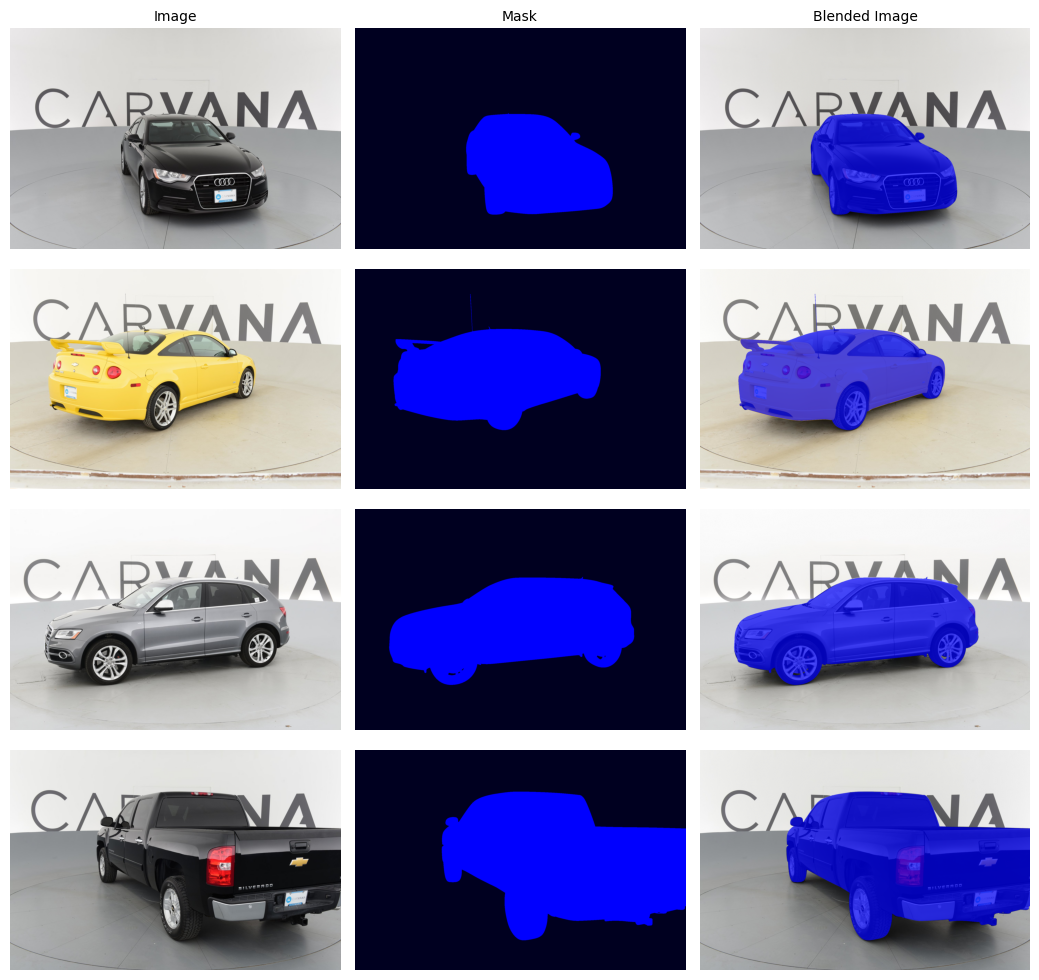

In [22]:
plot_image_masks(image_paths, mask_paths)